In [282]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


### Define functions used throughout the experiments

In [283]:
def generateX(n):
    x = np.random.randn(n)
    return(x)


def generateLinearY(x, beta, b, sigma):
    n = len(x)
    eps = np.random.randn(n)
    y = beta*x + b + eps*sigma
    return y


def generateNonlinearY(x, sigma):
    def s(x):
        g = [1 if x[i] > 0 else abs(x[i])**2 + 1 for i in range(len(x))]
        return np.array(g)

    n = len(x)
    eps = np.random.randn(n) 
    y = 1.5*np.maximum(x, 0) + sigma * s(x) * eps
    return y


def splitData(x, y, n1):
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    return x1, y1, x2, y2


In [284]:
def linearPredictionInterval(xtrain, ytrain, xnew, alpha):
    xtrain = xtrain.reshape(-1, 1)
    n1 = xtrain.shape[0]
    
    res = LinearRegression().fit(xtrain, ytrain)

    betahat = res.coef_
    bhat = res.intercept_

    sigmahat = np.sqrt( np.sum((ytrain - xtrain @ betahat - bhat)**2)/(n1-2) )

    xtilde = np.hstack([xtrain, np.ones((n1, 1))])
    xtx = xtilde.T @ xtilde
    
    yhat = xnew*betahat + bhat
    t = stats.norm.ppf(1-alpha/2)
    xnew1 = np.hstack([xnew.reshape(-1,1), np.ones((len(xnew), 1))])

    mat = xnew1 @ np.linalg.inv(xtx) @ xnew1.T
    s = sigmahat*np.sqrt(1 + mat.diagonal())
    
    return np.hstack([(yhat - t*s).reshape(-1, 1), (yhat + t*s).reshape(-1,1)])



def conformalInterval(resids, ypred_new, alpha):
    n = len(resids)
    t = np.quantile(abs(resids), np.ceil((1-alpha)*(n+1))/n )
    return np.hstack([(ypred_new - t).reshape(-1, 1), (ypred_new + t).reshape(-1,1)])


In [285]:
n = 1000
ntrain = 400

sigma = 0.1
alpha = 0.05

### Experiment 1:

* true model is linear with homoskedastic Gaussian noise
* we fit a linear model
* we construct prediction interval using linear model

Percent covered on test data:  0.9433333333333334


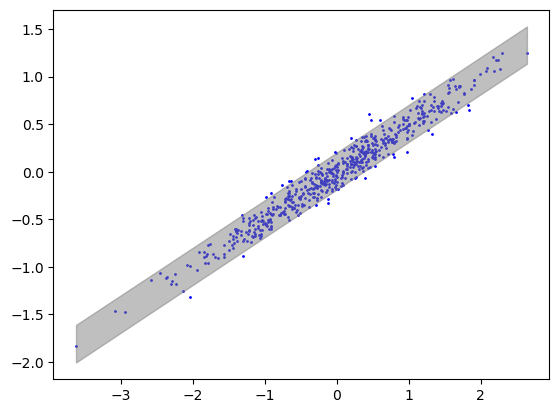

In [286]:

beta0 = .5
b0 = 0

x = generateX(n)

y = generateLinearY(x, beta0, b0, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

intervals = linearPredictionInterval(xtrain, ytrain, xtest, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction interval 
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

eps = np.random.randn(len(xgrid))
ygrid = generateLinearY(xgrid, beta0, b0, sigma)

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')


### Experiment 2

* true model is non-linear with heteroskedastic gaussian noise
* we fit linear model
* we use linear model prediction interval

Percent covered on test data:  0.94


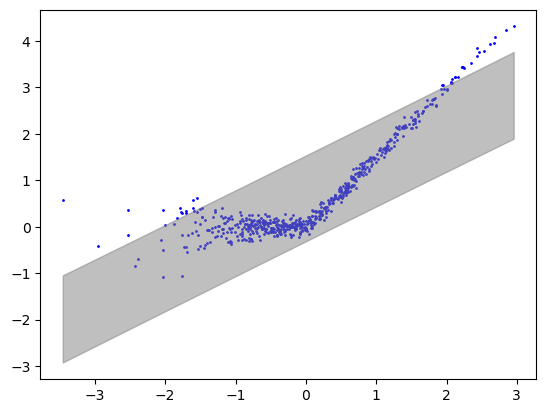

In [287]:

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

intervals = linearPredictionInterval(xtrain, ytrain, xtest, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')


### Experiment 3

* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a linear model
* we use conformal prediction interval

Percent covered on test data:  0.935


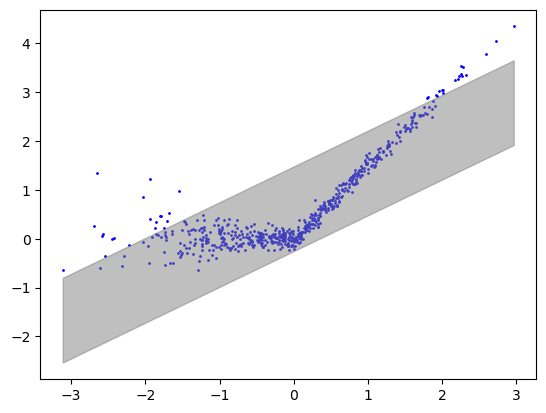

In [288]:

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

regressor = LinearRegression().fit(xtrain1.reshape(-1, 1), ytrain1)
resids = ytrain2 - regressor.predict(xtrain2.reshape(-1, 1))

intervals = conformalInterval(resids, regressor.predict(xtest.reshape(-1, 1)), alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

### Experiment 4

* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a nonlinear model
* we use conformal prediction interval

epoch 0
epoch 20
epoch 40
epoch 60
epoch 80
epoch 100
epoch 120
epoch 140
epoch 160
epoch 180
Percent covered on test data:  0.9866666666666667


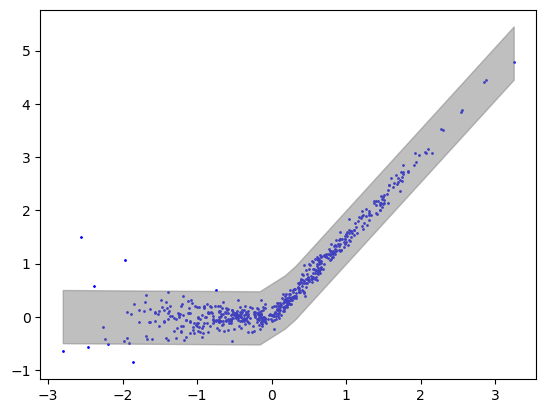

In [289]:

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data

class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x.squeeze()
    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

model = NNet(1, 5)
lr = 0.1
epochs = 200
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train1)
    loss = criterion(y_pred, y_train1)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print('epoch', epoch)


## compute residues on second half of training data
## and prediction intervals on test data

x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)
resids = ytrain2 - model(x_train2).squeeze().detach().numpy()

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
y_pred = model(x_test).squeeze().detach().numpy()

intervals = conformalInterval(resids, y_pred, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')